In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import string

import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
#from gensim.models import Word2Vec

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data Preprocessing

In [2]:
file_list = ["/Data/review"+str(i)+".csv" for i in range(1,11)]

In [3]:
data_list = list()
for file in file_list:
    data_list.append(pd.read_csv(file))

In [4]:
import re

for index, da in enumerate(data_list):
    stars = da["stars"].tolist()
    stars_value = [int(re.findall(r'\d+', i)[0]) for i in stars]
    da["stars"] = stars_value
    da["ID"] = list(np.repeat(index+1,len(da), axis=0))
    

In [5]:
df_all = pd.concat(data_list)

In [6]:
df_all.shape

(21353, 6)

In [7]:
##remove some character references such as “&amp;amp;”
df_all['review'] = [i.replace("&amp;amp;", '').replace("\'",'') for i in df_all['review']]

In [8]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all = df_all.sort_values(by=['date'])
df_all = df_all.set_index('date')

df_all.head()

,location,review,stars,username,ID
date,,,,,
2004-10-20,"Palo Alto, CA",5 Stars arent enough for this fantastic breakf...,5,Mary C.,3
2005-03-01,"San Francisco, CA",This little hole in the wall taqueria is writt...,4,Tanger T.,7
2005-03-01,"San Francisco, CA",Words cannot describe how much I miss this pla...,5,Tanger T.,2
2005-03-20,"San Francisco, CA",Casual seafood restaurant downtonw on the wate...,4,Patrick B.,2
2005-03-22,"Los Angeles, CA",This place is one of a kind. For great Cajun f...,4,Roopa D.,10


### Exploratory Data Analysis

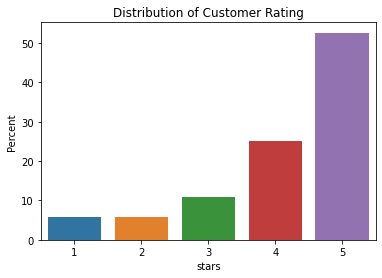

In [9]:
ax = sns.barplot(data=df_all, x='stars', y='stars', estimator=lambda x: len(x) / len(df_all) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

In [10]:
FreqDist(list(df_all["stars"]))

FreqDist({5: 11235, 4: 5362, 3: 2298, 2: 1240, 1: 1218})

## Text Mining

### Stopwords

Some worad are not informative such as “a”, “an”, “the”, “and” in English.

Two sets of stopwords from `nltk.corpus` and `sklearn.feature_extraction.stop_words`.

In [11]:
#import nltk
#nltk.download('stopwords')

In [12]:
# set stop words
my_stop_words = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))

### WordCloud

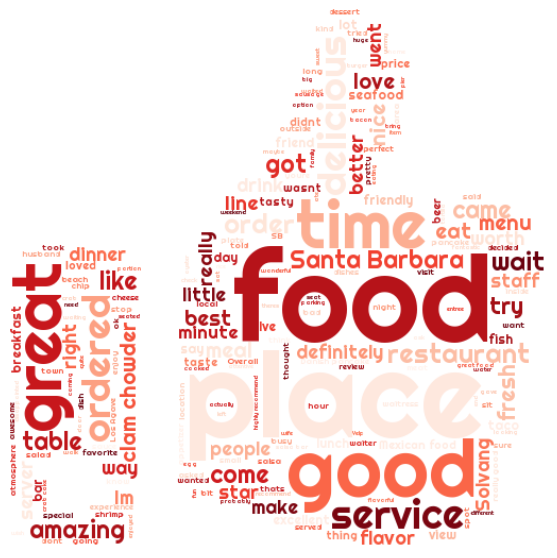

In [13]:
pos_mask = np.array(Image.open('thumbs-up-solid.png'))

# concatenate all the reviews into one single string 
full_text = ' '.join(df_all['review'])
cloud_no_stopword = WordCloud(background_color='white',mask=pos_mask, stopwords=my_stop_words,colormap="Reds",
                              font_path='/Users/apple/234/Righteous/Righteous-Regular.ttf').generate(full_text)
plt.figure(figsize=(20,10))
plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

From the above wordcloud plot:

* good: overall, postive reviews. These may be due to its service, time, etc.
* place: location matters?

### Tokenization and Bag-of-Words (BoW)

#### Unigram Dist

In [14]:
stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

In [15]:
def text_process(data):
    '''
    Takes in a df in format of [text] performs the following:
    1. Lower capital letters
    2. Remove all punctuation
    3. Remove all stopwords
    4. Reduce words to their word stem
    5. Return a list of words
    
    '''
    for i in range(len(data)):
        line = data[i]
        line = line.lower() # lower case
        translation = str.maketrans("","", string.punctuation);
        line = line.translate(translation)
        split = word_tokenize(line)
         # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        filtered = []
        for token in split:
            if re.search('[a-zA-Z]', token):    
                filtered.append(token)
        word = [i for i in filtered if i not in my_stop_words]
        
        d = [stemmer.stem(word) for word in word] 
        d = [wordnet_lemmatizer.lemmatize(word) for word in d]
        data[i] = d
    return data

In [16]:
reviews = list(df_all["review"])
reviews = text_process(reviews)

review_all = list()

for i in range(len(reviews)):
    review_all = review_all + reviews[i]

In [17]:
token_dist = FreqDist(review_all)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])
dist

,Word,Frequency
0,food,16858
1,place,12714
2,good,12435
3,great,10179
4,order,10123
5,wait,7891
6,servic,7353
7,time,6686
8,like,6218
9,restaur,5761


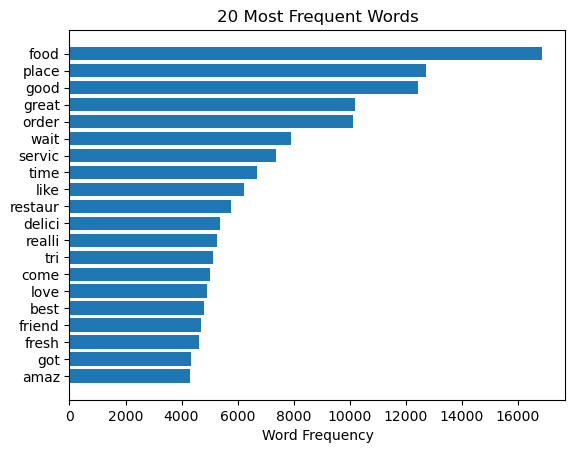

In [18]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(dist["Word"]))
ax.barh(y_pos, dist["Frequency"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(dist["Word"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Word Frequency')
ax.set_title('20 Most Frequent Words')

plt.show();

#### Bigram Dist

Under the Bag-of-Words approach, the word order is discarded. However, in many cases, the sequence of words is very important.

In [19]:
vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(2,2))
bigrams = vect.fit_transform(df_all['review'])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(20)

In [20]:
bigram_frequency

,bigram,frequency
320398,santa barbara,3824
72082,clam chowder,2395
234801,mexican food,1531
94060,danish pancakes,1090
166073,great food,1041
299097,really good,987
218708,los agaves,894
145751,food good,894
178449,highly recommend,834
318075,salsa bar,828


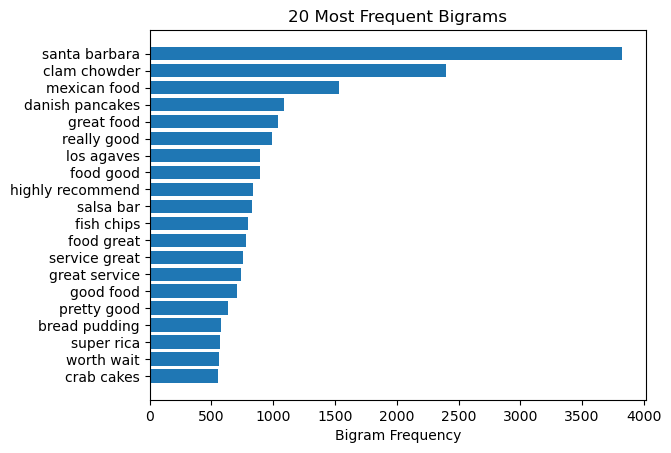

In [21]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(bigram_frequency["bigram"]))
ax.barh(y_pos, bigram_frequency["frequency"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(bigram_frequency["bigram"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Bigram Frequency')
ax.set_title('20 Most Frequent Bigrams')

plt.show();

* Top 3: clam chowder (Brophy Bros - Santa Barbara), mexican food (Los Agaves), danish pancakes (Paula's Pancake House)
* great food, food good, food great, good food: top 10 restaurants' postive rates are due to their food.

## Classification

#### Label:

1-2:negative, 4-5: postive

In [22]:
df_update = df_all.loc[~(df_all["stars"]==3),:]
df_update["label"] = np.where(df_update["stars"]>=4,True,False)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
df_update.head()

,location,review,stars,username,ID,label
date,,,,,,
2004-10-20,"Palo Alto, CA",5 Stars arent enough for this fantastic breakf...,5,Mary C.,3,True
2005-03-01,"San Francisco, CA",This little hole in the wall taqueria is writt...,4,Tanger T.,7,True
2005-03-01,"San Francisco, CA",Words cannot describe how much I miss this pla...,5,Tanger T.,2,True
2005-03-20,"San Francisco, CA",Casual seafood restaurant downtonw on the wate...,4,Patrick B.,2,True
2005-03-22,"Los Angeles, CA",This place is one of a kind. For great Cajun f...,4,Roopa D.,10,True


In [24]:
df_update.shape

(19055, 6)

In [25]:
FreqDist(list(df_update["label"]))

FreqDist({True: 16597, False: 2458})

In [26]:
pos = df_update.loc[df_update['label']==True]
pos2 = pos.sample(n=2500,random_state=100)
pos2.shape

(2500, 6)

In [27]:
neg = df_update.loc[df_update['label']==False]
neg.shape

(2458, 6)

In [28]:
df_new = pd.concat([pos2,neg]).sort_index()
##remove some character references such as “&amp;amp;”
df_new['review'] = [i.replace("&amp;amp;", '').replace("\xa0", '').lower() for i in df_new['review']]
df_new.head()

,location,review,stars,username,ID,label
date,,,,,,
2005-03-01,"San Francisco, CA",this little hole in the wall taqueria is writt...,4,Tanger T.,7,True
2005-03-20,"San Francisco, CA",casual seafood restaurant downtonw on the wate...,4,Patrick B.,2,True
2005-08-31,"San Francisco, CA","at first glance, this nondescript - except for...",5,Gourmet G.,7,True
2006-09-10,"San Francisco, CA",casual seafood house located in the harbor. ex...,5,Brian H.,2,True
2006-09-12,"Venice, CA",as far as cheap taco joints go - this is a 4 s...,4,A. P.,7,True


In [29]:
# TfidfVectorizer Transform
transformer = TfidfVectorizer(stop_words ='english', ngram_range=(2,2), max_features=300)  # "ignore terms that appear in less than 1% of the documents".
cvectorizer = transformer.fit(df_new['review'])
transformed = cvectorizer.transform(df_new['review'])

In [30]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(transformed,list(df_new["label"]),test_size=0.3,random_state=15)

#### Logistic Regression

In [32]:
log_reg = LogisticRegression().fit(X_train, Y_train)
y_pred_lg = log_reg.predict_proba(X_test)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.861


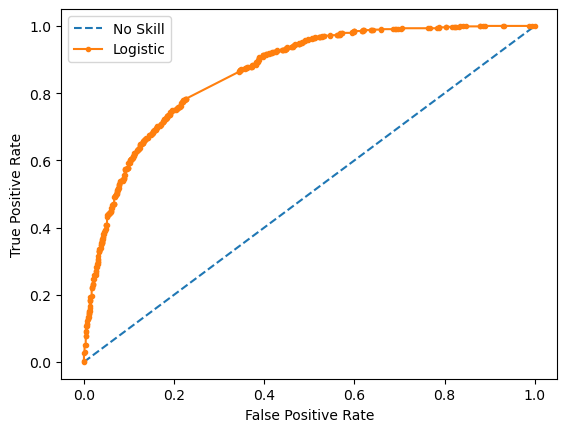

In [33]:
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = y_pred_lg[:,1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [34]:
gmean = np.sqrt(lr_tpr * (1 - lr_fpr))
optimal_idx = np.argmax(gmean)
optimal_threshold_lg = _[optimal_idx]

In [35]:
optimal_threshold_lg

0.4665164698135714

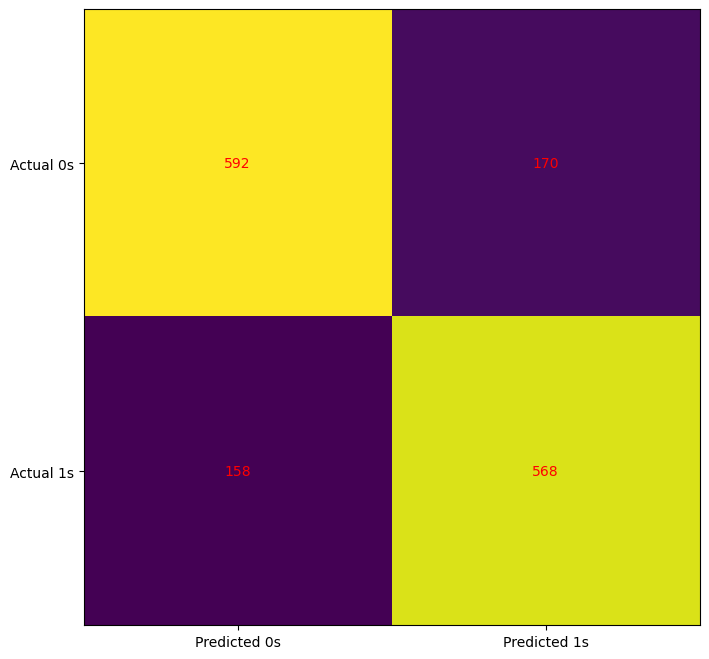

In [36]:
cm = confusion_matrix(Y_test, [i >= optimal_threshold_lg for i in lr_probs ])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [38]:
print(classification_report(Y_test, [i >= optimal_threshold_lg for i in lr_probs ]))

              precision    recall  f1-score   support

       False       0.79      0.78      0.78       762
        True       0.77      0.78      0.78       726

    accuracy                           0.78      1488
   macro avg       0.78      0.78      0.78      1488
weighted avg       0.78      0.78      0.78      1488



#### Naive Bayes

In [39]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, Y_train)
y_pred_nb = nb_classifier.predict_proba(X_test)

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.861


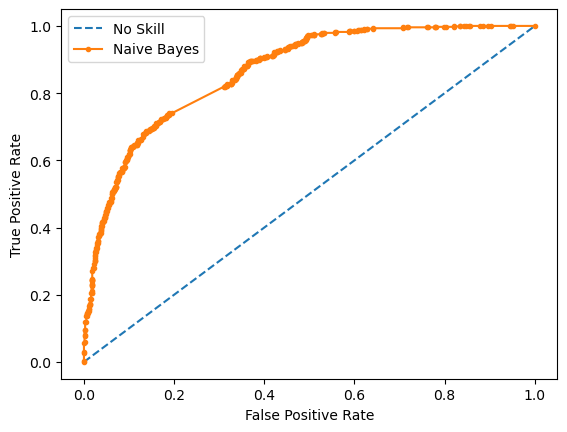

In [40]:
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs2 = y_pred_nb[:,1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc2 = roc_auc_score(Y_test, lr_probs2)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr2, lr_tpr2, _ = roc_curve(Y_test, lr_probs2)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr2, lr_tpr2, marker='.', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [41]:
gmean2 = np.sqrt(lr_tpr2 * (1 - lr_fpr2))
optimal_idx2 = np.argmax(gmean2)
optimal_threshold_nb = _[optimal_idx2]

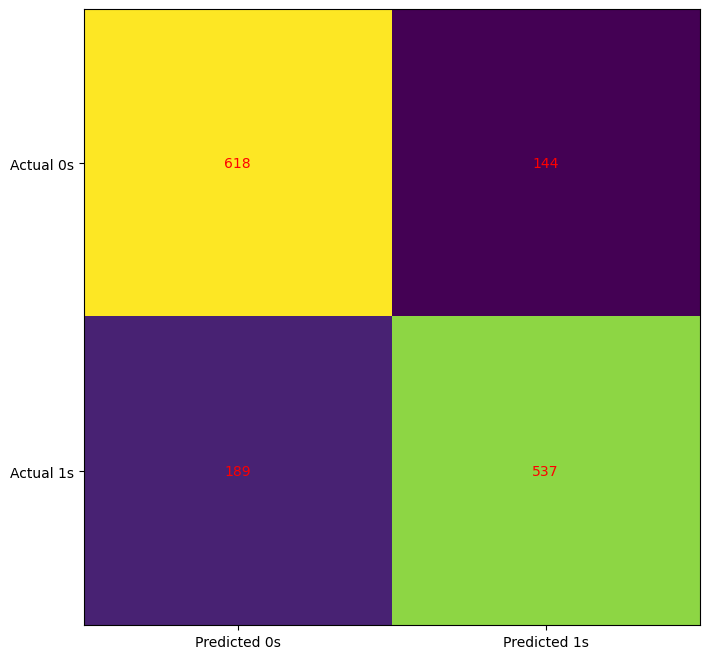

In [42]:
cm = confusion_matrix(Y_test, [i >= optimal_threshold_nb for i in lr_probs2 ])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [43]:
print(classification_report(Y_test, [i >= optimal_threshold_nb for i in lr_probs2 ]))

              precision    recall  f1-score   support

       False       0.77      0.81      0.79       762
        True       0.79      0.74      0.76       726

    accuracy                           0.78      1488
   macro avg       0.78      0.78      0.78      1488
weighted avg       0.78      0.78      0.78      1488



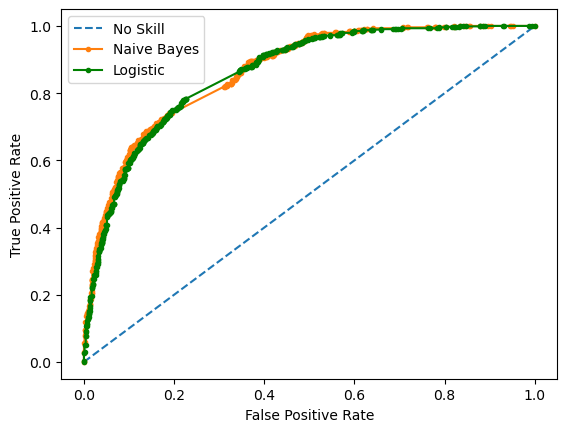

In [44]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr2, lr_tpr2, marker='.', label='Naive Bayes')
plt.plot(lr_fpr, lr_tpr, color='green',marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### CNN

In [46]:
#line = ' '.join(list(df_new['review']))
#translation = str.maketrans("","", string.punctuation);
#line = line.translate(translation)
#split = word_tokenize(line)
#split_uni = list(set(split))

# filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
#filtered = []
#for token in split_uni:
#    if re.search('[a-zA-Z]', token):
#        filtered.append(token)
#words = [i for i in filtered if i not in my_stop_words]
#tokens = list()
#for word in split_uni:
#    if word.isalpha() and word not in my_stop_words:
#        tokens.append(word)

In [48]:
#textfile = open("vocabulary.txt", "w")
#for element in tokens:
#    textfile.write(element + "\n")
#textfile.close()

In [49]:
#X_train, X_test, Y_train, Y_test = train_test_split(list(df_new["review"]),list(df_new["label"]),test_size=0.3,random_state=15)

In [50]:
#Y_train = [int(i) for i in Y_train]
#Y_test = [int(i) for i in Y_test]

In [51]:
#d = {'col1': Y_train, 'col2': X_train}
#train_data = pd.DataFrame(data=d)
#train_data.head()

In [52]:
#d2 = {'col1': Y_test, 'col2': X_test}
#valid_data = pd.DataFrame(data=d2)
#valid_data.head()

In [53]:
#train_data.to_csv('train_data.txt',sep=' ', index=False, header=False)
#valid_data.to_csv('valid_data.txt',sep=' ', index=False, header=False)